# Convolutional Neural Network

## Import Libraries

In [ ]:
from google.colab import drive
import pandas as pd
import numpy as np

from keras.callbacks import EarlyStopping
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Input, Sequential
from keras.layers import Dense, Input, Embedding, Dropout, SpatialDropout1D, Activation
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization
from keras.optimizers import Adam

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import KFold
import scipy.stats
from keras import backend as K

from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import classification_report

## Load data

In [ ]:
drive.mount('/content/drive', force_remount = True)
root_dir = '/content/drive/MyDrive/ProgettoAML/dataset_preprocessed/'
X_train = pd.read_csv(root_dir+'x_train_preprocessed.csv')
y_train = pd.read_csv(root_dir+'y_train_preprocessed.csv')

X_test = pd.read_csv(root_dir+'x_test_preprocessed.csv')
y_test = pd.read_csv(root_dir+'y_test_preprocessed.csv')

Mounted at /content/drive


## Model parameters

In [ ]:
# number of unique words we want to use (or: number of rows in incoming embedding vector)
max_features = 20000 

# max number of words in a comment to use (or: number of columns in incoming embedding vector)
max_len = 200 

# dimension of the embedding variable (or: number of rows in output of embedding vector)
embedding_dims = 128

# Weight initializer
initializer = initializers.GlorotUniform(seed=42) 

#Early stopping
callback = EarlyStopping(monitor='val_loss', patience=2)

# k-fold crossvalidation
kfold = KFold(n_splits=10, shuffle=False)

# dict for final plot
data_dict = {}
data_dict['category'] = ['Model_1','Model_2','Model_3', 'Model_4', 'Model_5']
data_dict['lower'] = []
data_dict['mean'] = []
data_dict['upper'] = []


In [ ]:
def plot_history(network_history, n_epochs):
    x_plot = list(range(1,n_epochs+1))
    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

    
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h
    
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes, cmap=["#FFFFFF"], linewidths=1, linecolor="#000000")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_xlabel('Predicted')
    axes.set_ylabel('Actual')
    axes.set_title("Confusion Matrix for the class - " + class_label)

## Model 1

In [ ]:
# instantiate CNN model
cnn_hist = []
fold_no = 0
cnn_model = []

for train, test in kfold.split(X_train, y_train):
  cnn_model.append(Sequential())
  cnn_model[fold_no].add(Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims))
  cnn_model[fold_no].add(SpatialDropout1D(0.3))
  cnn_model[fold_no].add(Conv1D(filters=20, kernel_size=4, padding='same', activation='relu', kernel_initializer=initializer)) # ... 20 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
  cnn_model[fold_no].add(BatchNormalization()) # add normalization layer
  cnn_model[fold_no].add(GlobalMaxPool1D()) # add pooling layer 
  cnn_model[fold_no].add(Dropout(0.3))
  cnn_model[fold_no].add(Dense(20, activation='relu', kernel_initializer=initializer ))
  cnn_model[fold_no].add(Dense(6, activation='sigmoid', kernel_initializer=initializer))

  cnn_model[fold_no].compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', f1_m])

  if fold_no == 0:
    print(cnn_model[fold_no].summary())


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  cnn_hist.append(cnn_model[fold_no].fit(X_train.iloc[train], y_train.iloc[train], batch_size=256, 
                          epochs=10, validation_data=(X_train.iloc[test], y_train.iloc[test]), verbose=1, callbacks=callback)) 
  fold_no = fold_no + 1


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 200, 128)          2560000   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 200, 128)          0         
_________________________________________________________________
conv1d (Conv1D)              (None, 200, 20)           10260     
_________________________________________________________________
batch_normalization (BatchNo (None, 200, 20)           80        
_________________________________________________________________
global_max_pooling1d (Global (None, 20)                0         
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 20)                4

History for fold 0 ...


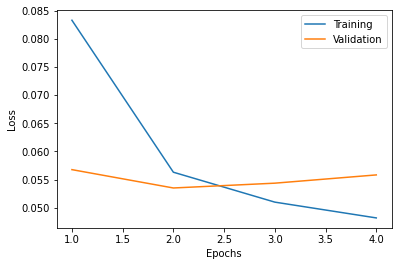

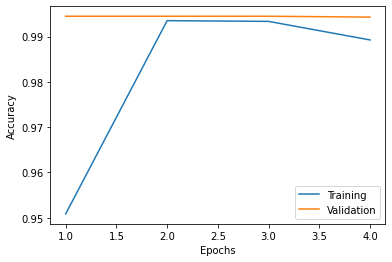

History for fold 1 ...


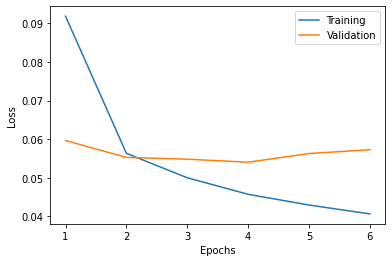

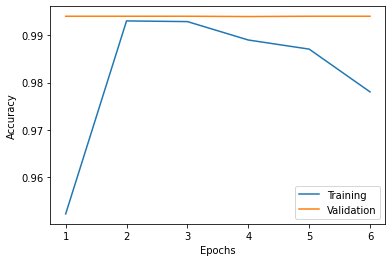

History for fold 2 ...


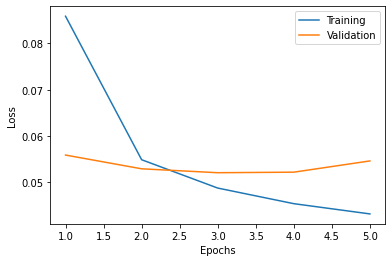

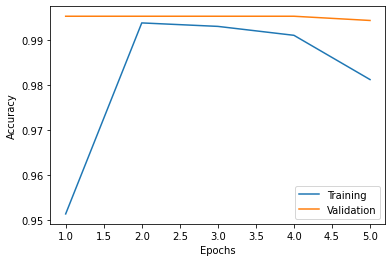

History for fold 3 ...


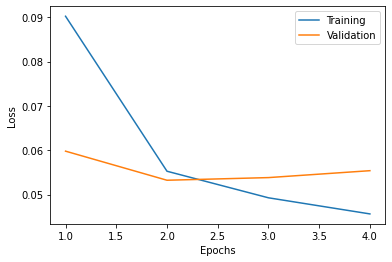

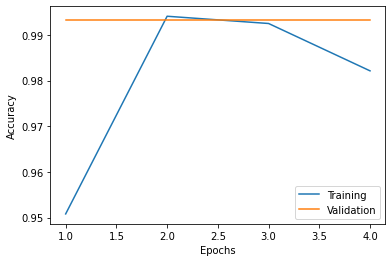

History for fold 4 ...


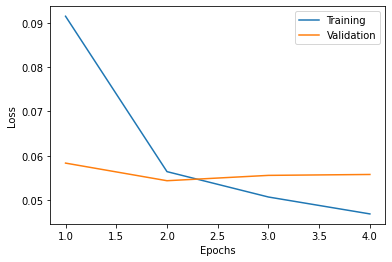

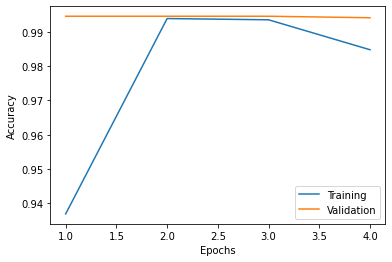

History for fold 5 ...


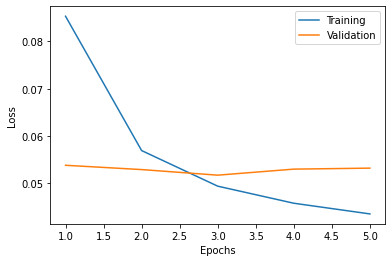

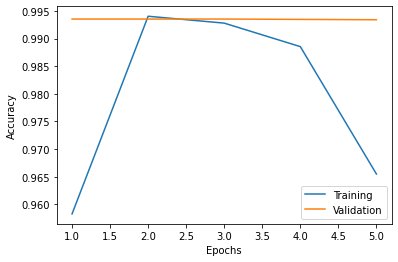

History for fold 6 ...


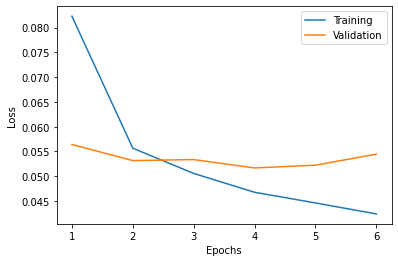

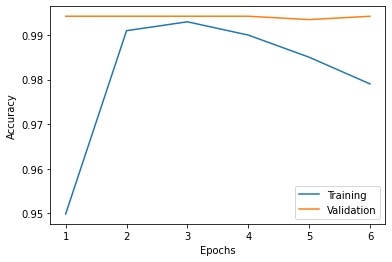

History for fold 7 ...


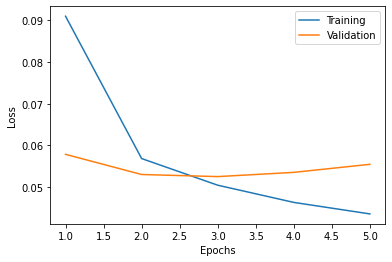

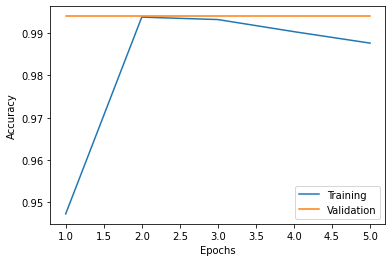

History for fold 8 ...


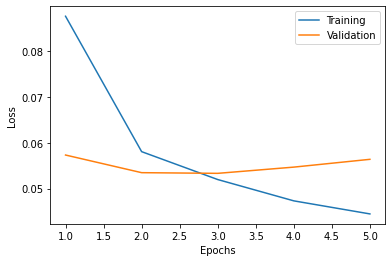

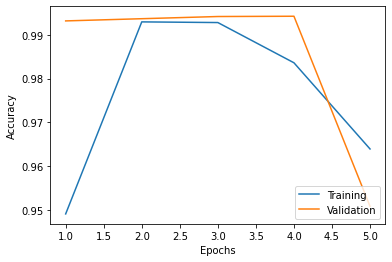

History for fold 9 ...


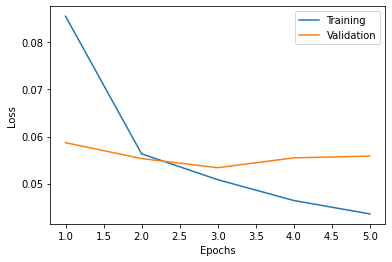

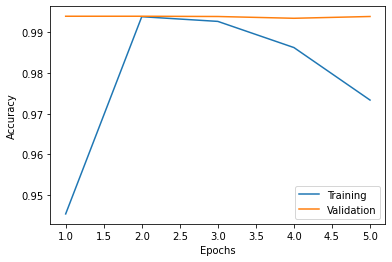

In [ ]:
for hist in range(len(cnn_hist)):
  print(f'History for fold {hist} ...')
  plot_history(cnn_hist[hist], len(cnn_hist[hist].history['val_loss']))

In [ ]:
f1_scores_model = []

for fold in range(10):
  epoch =  np.argmin(cnn_hist[fold].history['val_loss'], axis=0)
  f1_scores_model.append(cnn_hist[fold].history['val_f1_m'][epoch])

f1_scores_model

[0.6801303625106812,
 0.7003413438796997,
 0.6997670531272888,
 0.6929552555084229,
 0.6950724720954895,
 0.7077414989471436,
 0.6899191737174988,
 0.6801437735557556,
 0.6897087097167969,
 0.7038013935089111]

## Model 2

In [ ]:
# instantiate CNN model
cnn_hist2 = []
fold_no = 0
cnn_model2 = []

for train, test in kfold.split(X_train, y_train):
  cnn_model2.append(Sequential())
  cnn_model2[fold_no].add(Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims))
  cnn_model2[fold_no].add(SpatialDropout1D(0.3))
  cnn_model2[fold_no].add(Conv1D(filters=30, kernel_size=4, padding='same', activation='relu', kernel_initializer=initializer)) # ... 30 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
  cnn_model2[fold_no].add(BatchNormalization()) # add normalization layer
  cnn_model2[fold_no].add(GlobalMaxPool1D()) # add pooling layer 
  cnn_model2[fold_no].add(Dropout(0.3))
  cnn_model2[fold_no].add(Dense(20, activation='relu', kernel_initializer=initializer ))
  cnn_model2[fold_no].add(Dense(6, activation='sigmoid', kernel_initializer=initializer))

  cnn_model2[fold_no].compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', f1_m])

  if fold_no == 0:
    print(cnn_model2[fold_no].summary())


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  cnn_hist2.append(cnn_model2[fold_no].fit(X_train.iloc[train], y_train.iloc[train], batch_size=256, 
                          epochs=10, validation_data=(X_train.iloc[test], y_train.iloc[test]), verbose=1, callbacks=callback)) 
  fold_no = fold_no + 1

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 200, 128)          2560000   
_________________________________________________________________
spatial_dropout1d_10 (Spatia (None, 200, 128)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 200, 30)           15390     
_________________________________________________________________
batch_normalization_10 (Batc (None, 200, 30)           120       
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 30)                0         
_________________________________________________________________
dropout_10 (Dropout)         (None, 30)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 20)              

History for fold 0 ...


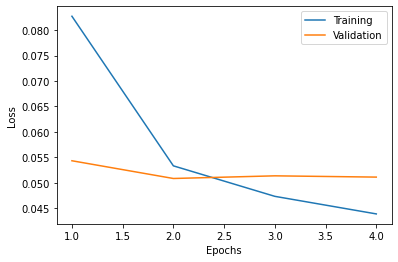

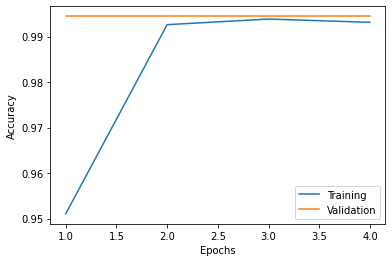

History for fold 1 ...


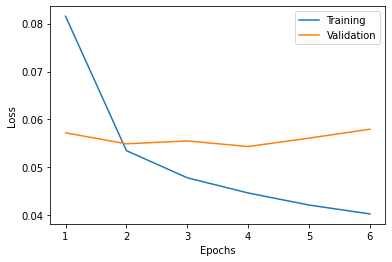

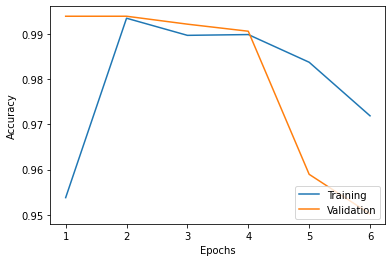

History for fold 2 ...


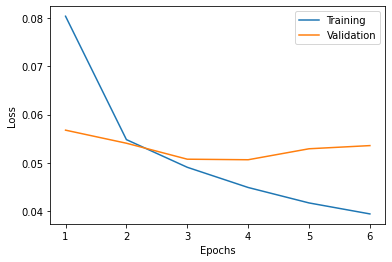

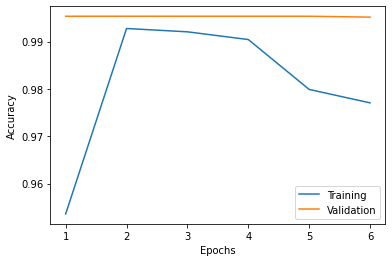

History for fold 3 ...


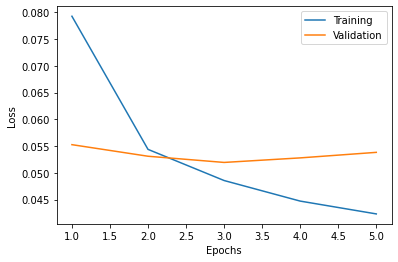

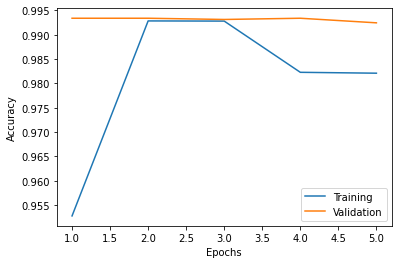

History for fold 4 ...


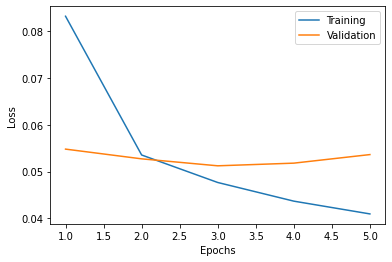

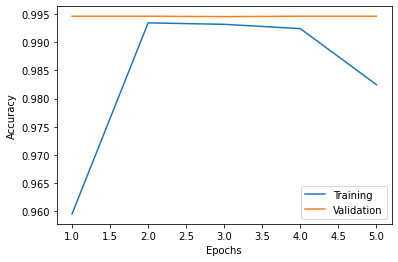

History for fold 5 ...


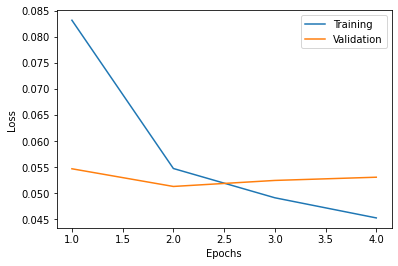

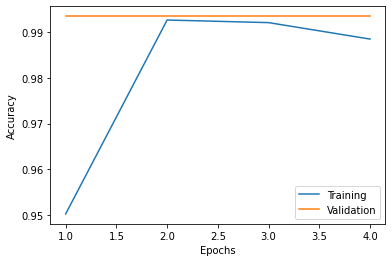

History for fold 6 ...


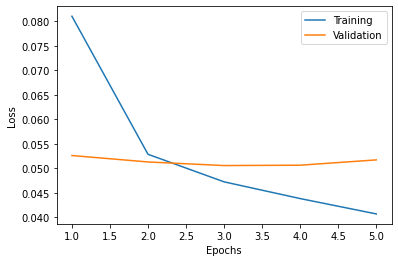

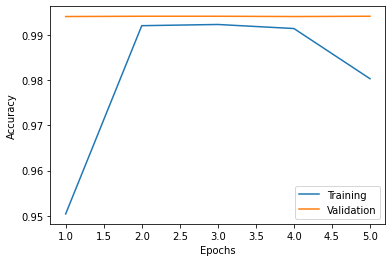

History for fold 7 ...


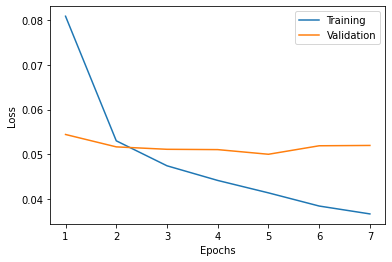

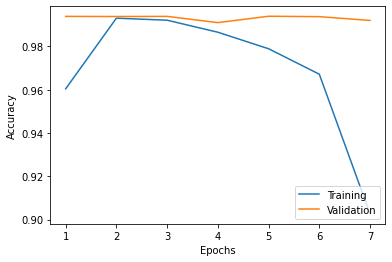

History for fold 8 ...


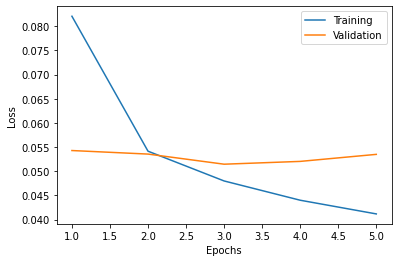

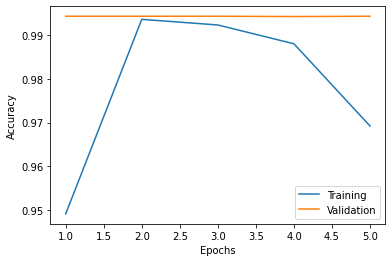

History for fold 9 ...


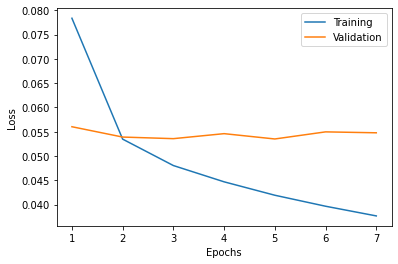

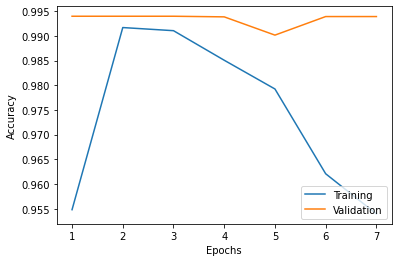

In [ ]:
for hist in range(len(cnn_hist2)):
  print(f'History for fold {hist} ...')
  plot_history(cnn_hist2[hist], len(cnn_hist2[hist].history['val_loss']))

In [ ]:
f1_scores_model2 = []

for fold in range(10):
  epoch =  np.argmin(cnn_hist2[fold].history['val_loss'], axis=0)
  f1_scores_model2.append(cnn_hist2[fold].history['val_f1_m'][epoch])

f1_scores_model2

[0.7164174318313599,
 0.7082023620605469,
 0.726528525352478,
 0.7120717763900757,
 0.7246118187904358,
 0.6988440155982971,
 0.7195556163787842,
 0.7201860547065735,
 0.703268826007843,
 0.7235563397407532]

## Model 3

In [ ]:
# instantiate CNN model
cnn_hist3 = []
fold_no = 0
cnn_model3 = []

for train, test in kfold.split(X_train, y_train):
  cnn_model3.append(Sequential())
  cnn_model3[fold_no].add(Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims))
  cnn_model3[fold_no].add(SpatialDropout1D(0.3))
  cnn_model3[fold_no].add(Conv1D(filters=40, kernel_size=4, padding='same', activation='relu', kernel_initializer=initializer)) # ... 40 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
  cnn_model3[fold_no].add(BatchNormalization()) # add normalization layer
  cnn_model3[fold_no].add(GlobalMaxPool1D()) # add pooling layer 
  cnn_model3[fold_no].add(Dropout(0.3))
  cnn_model3[fold_no].add(Dense(20, activation='relu', kernel_initializer=initializer ))
  cnn_model3[fold_no].add(Dense(6, activation='sigmoid', kernel_initializer=initializer))

  cnn_model3[fold_no].compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', f1_m])

  if fold_no == 0:
    print(cnn_model3[fold_no].summary())


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  cnn_hist3.append(cnn_model3[fold_no].fit(X_train.iloc[train], y_train.iloc[train], batch_size=256, 
                          epochs=10, validation_data=(X_train.iloc[test], y_train.iloc[test]), verbose=1, callbacks=callback)) 
  fold_no = fold_no + 1

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_20 (Embedding)     (None, 200, 128)          2560000   
_________________________________________________________________
spatial_dropout1d_20 (Spatia (None, 200, 128)          0         
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 200, 40)           20520     
_________________________________________________________________
batch_normalization_20 (Batc (None, 200, 40)           160       
_________________________________________________________________
global_max_pooling1d_20 (Glo (None, 40)                0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 40)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 20)              

History for fold 0 ...


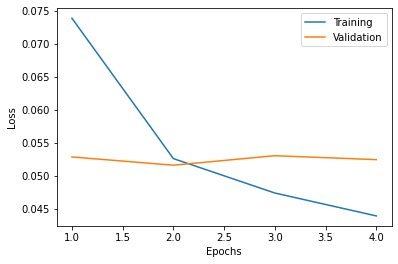

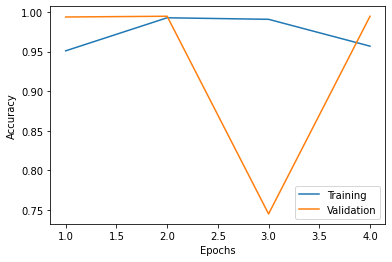

History for fold 1 ...


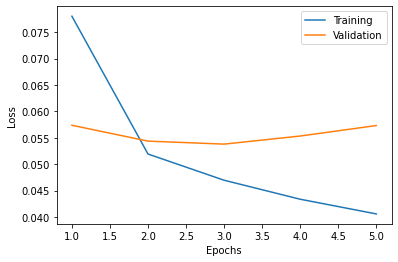

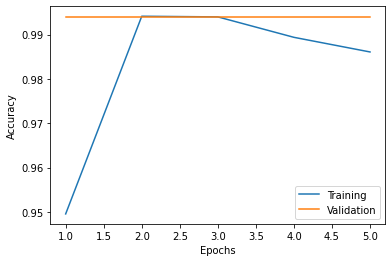

History for fold 2 ...


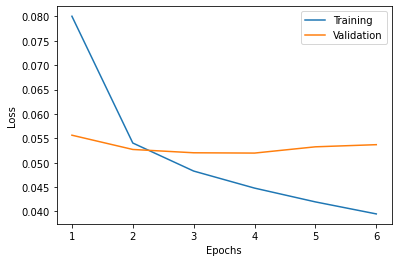

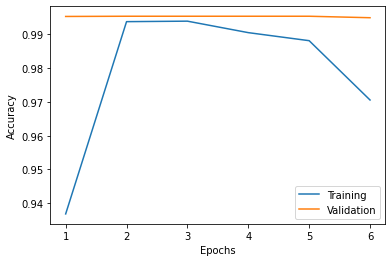

History for fold 3 ...


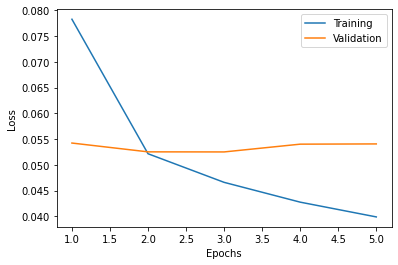

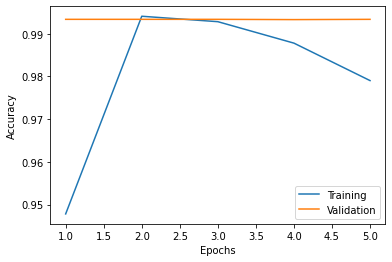

History for fold 4 ...


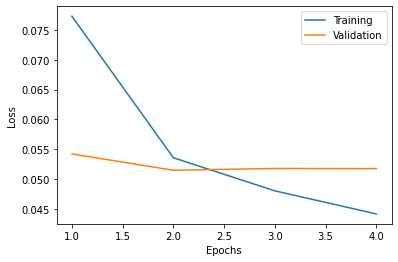

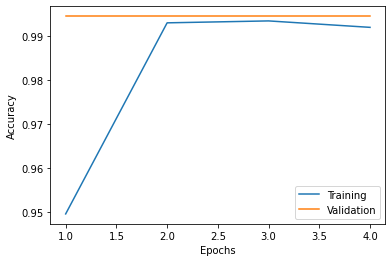

History for fold 5 ...


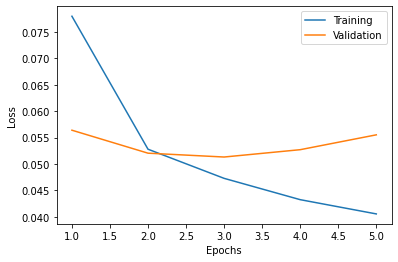

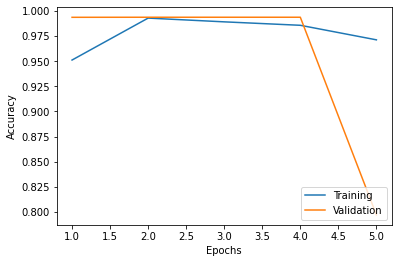

History for fold 6 ...


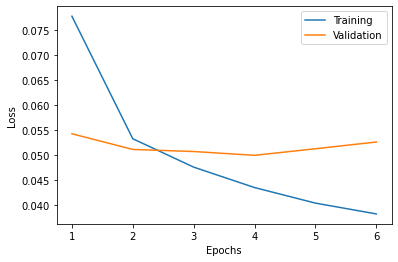

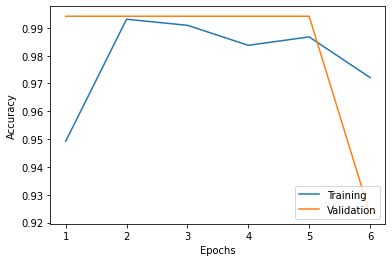

History for fold 7 ...


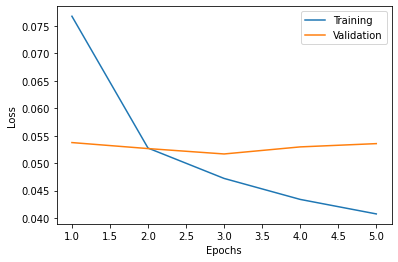

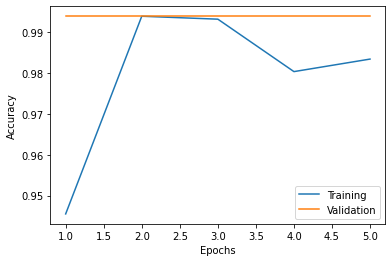

History for fold 8 ...


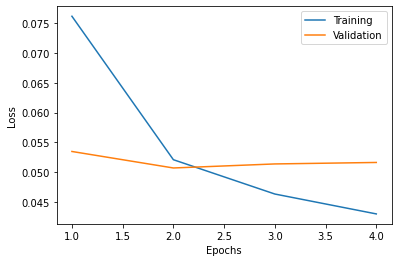

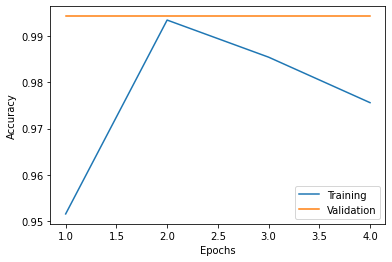

History for fold 9 ...


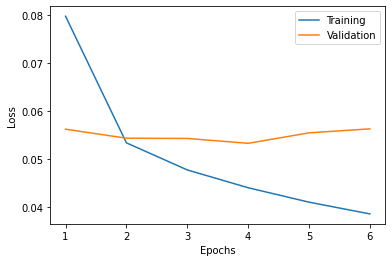

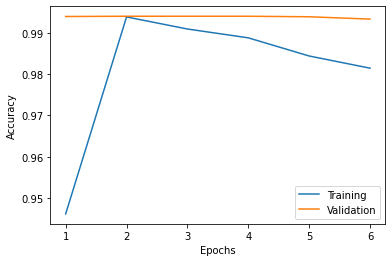

In [ ]:
for hist in range(len(cnn_hist3)):
  print(f'History for fold {hist} ...')
  plot_history(cnn_hist3[hist], len(cnn_hist3[hist].history['val_loss']))

In [ ]:
f1_scores_model3 = []

for fold in range(10):
  epoch =  np.argmin(cnn_hist3[fold].history['val_loss'], axis=0)
  f1_scores_model3.append(cnn_hist3[fold].history['val_f1_m'][epoch])

f1_scores_model3

[0.6875424981117249,
 0.7099026441574097,
 0.71686851978302,
 0.7141438722610474,
 0.7261266112327576,
 0.725949227809906,
 0.7279468774795532,
 0.711621105670929,
 0.698366641998291,
 0.7193970680236816]

## Model 4

In [ ]:
# instantiate CNN model
cnn_hist4 = []
fold_no = 0
cnn_model4 = []

for train, test in kfold.split(X_train, y_train):
  cnn_model4.append(Sequential())
  cnn_model4[fold_no].add(Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims))
  cnn_model4[fold_no].add(SpatialDropout1D(0.3))
  cnn_model4[fold_no].add(Conv1D(filters=50, kernel_size=4, padding='same', activation='relu', kernel_initializer=initializer)) # ... 50 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
  cnn_model4[fold_no].add(BatchNormalization()) # add normalization layer
  cnn_model4[fold_no].add(GlobalMaxPool1D()) # add pooling layer 
  cnn_model4[fold_no].add(Dropout(0.3))
  cnn_model4[fold_no].add(Dense(20, activation='relu', kernel_initializer=initializer ))
  cnn_model4[fold_no].add(Dense(6, activation='sigmoid', kernel_initializer=initializer))

  cnn_model4[fold_no].compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', f1_m])

  if fold_no == 0:
    print(cnn_model4[fold_no].summary())


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  cnn_hist4.append(cnn_model4[fold_no].fit(X_train.iloc[train], y_train.iloc[train], batch_size=256, 
                          epochs=10, validation_data=(X_train.iloc[test], y_train.iloc[test]), verbose=1, callbacks=callback)) 
  fold_no = fold_no + 1

Model: "sequential_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 200, 128)          2560000   
_________________________________________________________________
spatial_dropout1d_30 (Spatia (None, 200, 128)          0         
_________________________________________________________________
conv1d_30 (Conv1D)           (None, 200, 50)           25650     
_________________________________________________________________
batch_normalization_30 (Batc (None, 200, 50)           200       
_________________________________________________________________
global_max_pooling1d_30 (Glo (None, 50)                0         
_________________________________________________________________
dropout_30 (Dropout)         (None, 50)                0         
_________________________________________________________________
dense_60 (Dense)             (None, 20)              

History for fold 0 ...


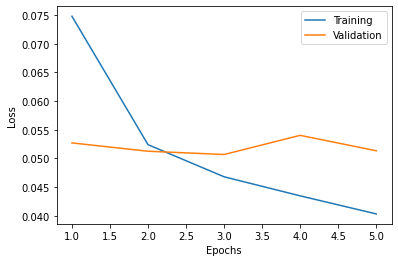

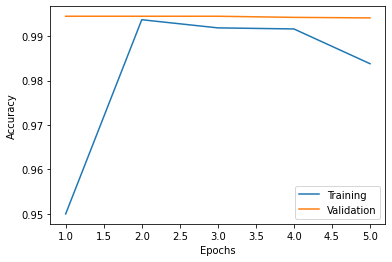

History for fold 1 ...


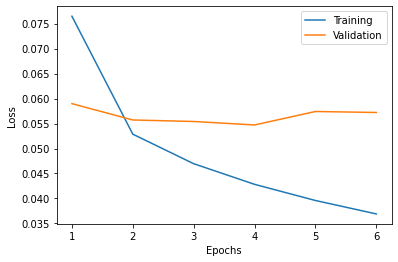

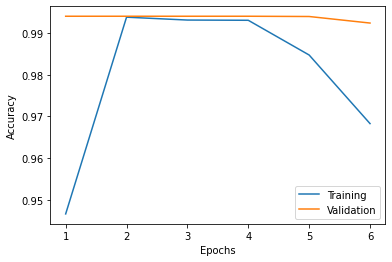

History for fold 2 ...


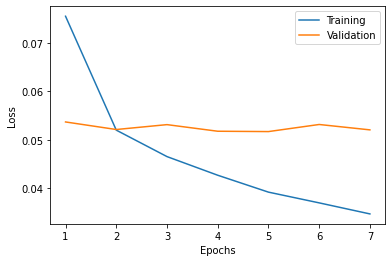

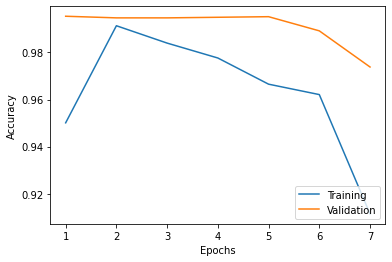

History for fold 3 ...


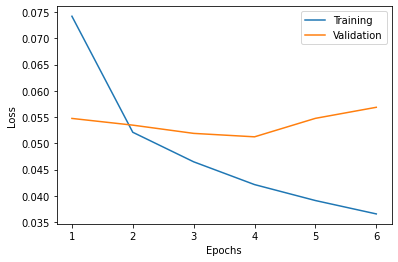

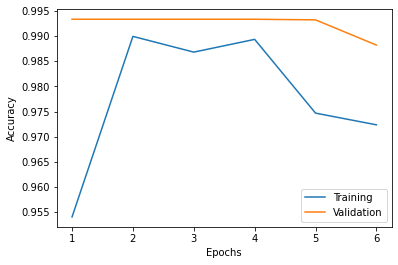

History for fold 4 ...


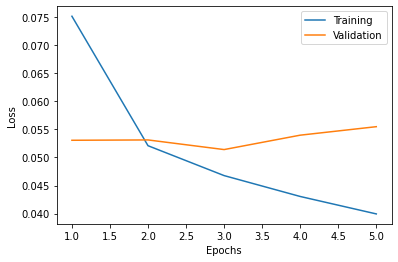

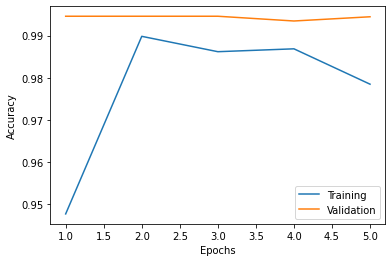

History for fold 5 ...


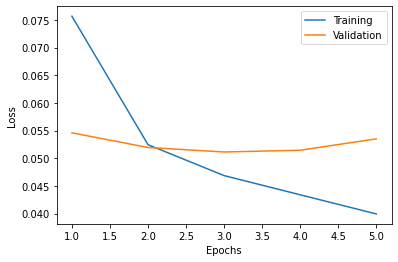

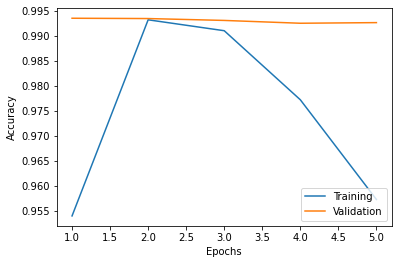

History for fold 6 ...


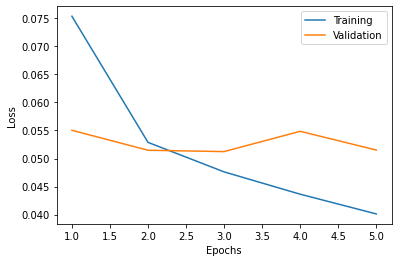

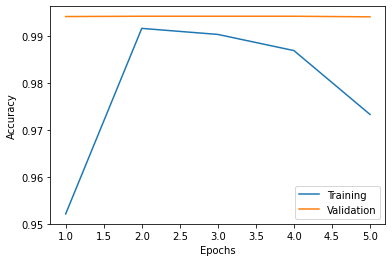

History for fold 7 ...


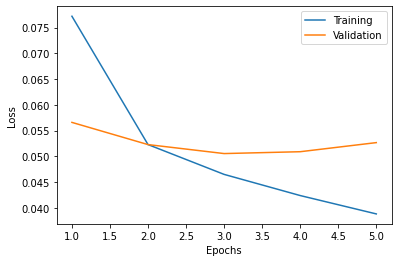

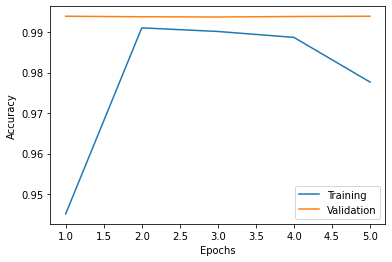

History for fold 8 ...


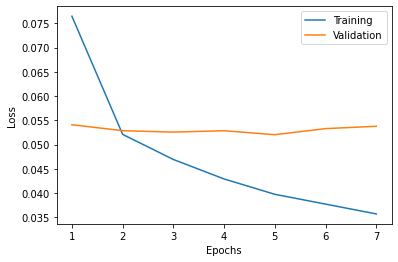

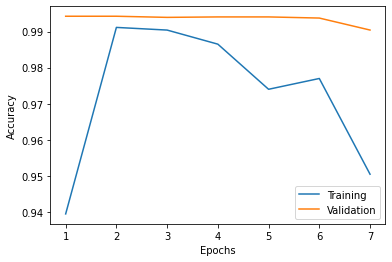

History for fold 9 ...


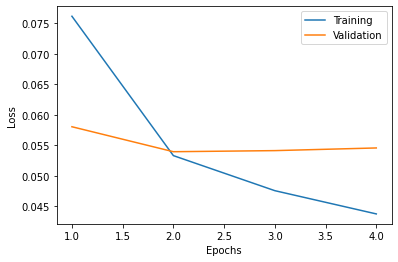

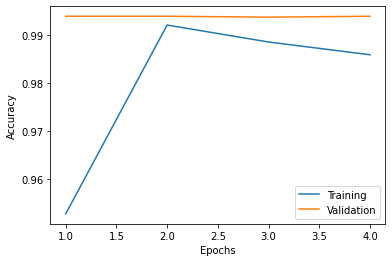

In [ ]:
for hist in range(len(cnn_hist4)):
  print(f'History for fold {hist} ...')
  plot_history(cnn_hist4[hist], len(cnn_hist4[hist].history['val_loss']))

In [ ]:
f1_scores_model4 = []

for fold in range(10):
  epoch =  np.argmin(cnn_hist4[fold].history['val_loss'], axis=0)
  f1_scores_model4.append(cnn_hist4[fold].history['val_f1_m'][epoch])

f1_scores_model4

[0.7146416902542114,
 0.7146106958389282,
 0.7289665937423706,
 0.7163459062576294,
 0.7176510095596313,
 0.708551824092865,
 0.7107649445533752,
 0.7137468457221985,
 0.7151299715042114,
 0.6900753378868103]

## Model 5

In [ ]:
# instantiate CNN model
cnn_hist5 = []
fold_no = 0
cnn_model5 = []

for train, test in kfold.split(X_train, y_train):
  cnn_model5.append(Sequential())
  cnn_model5[fold_no].add(Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims))
  cnn_model5[fold_no].add(SpatialDropout1D(0.3))
  cnn_model5[fold_no].add(Conv1D(filters=60, kernel_size=4, padding='same', activation='relu', kernel_initializer=initializer)) # ... 60 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
  cnn_model5[fold_no].add(BatchNormalization()) # add normalization layer
  cnn_model5[fold_no].add(GlobalMaxPool1D()) # add pooling layer 
  cnn_model5[fold_no].add(Dropout(0.3))
  cnn_model5[fold_no].add(Dense(20, activation='relu', kernel_initializer=initializer ))
  cnn_model5[fold_no].add(Dense(6, activation='sigmoid', kernel_initializer=initializer))

  cnn_model5[fold_no].compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', f1_m])

  if fold_no == 0:
    print(cnn_model5[fold_no].summary())


  # Generate a print
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')
  cnn_hist5.append(cnn_model5[fold_no].fit(X_train.iloc[train], y_train.iloc[train], batch_size=256, 
                          epochs=10, validation_data=(X_train.iloc[test], y_train.iloc[test]), verbose=1, callbacks=callback)) 
  fold_no = fold_no + 1



Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_40 (Embedding)     (None, 200, 128)          2560000   
_________________________________________________________________
spatial_dropout1d_40 (Spatia (None, 200, 128)          0         
_________________________________________________________________
conv1d_40 (Conv1D)           (None, 200, 60)           30780     
_________________________________________________________________
batch_normalization_40 (Batc (None, 200, 60)           240       
_________________________________________________________________
global_max_pooling1d_40 (Glo (None, 60)                0         
_________________________________________________________________
dropout_40 (Dropout)         (None, 60)                0         
_________________________________________________________________
dense_80 (Dense)             (None, 20)              

History for fold 0 ...


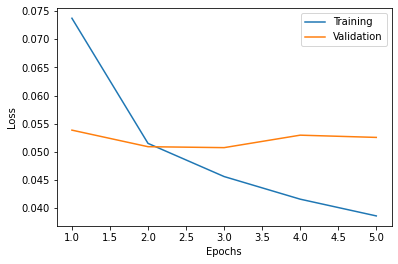

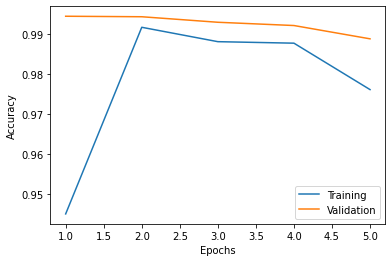

History for fold 1 ...


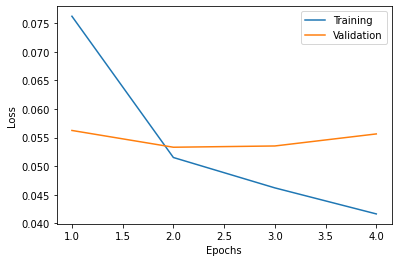

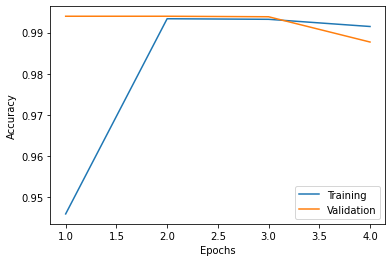

History for fold 2 ...


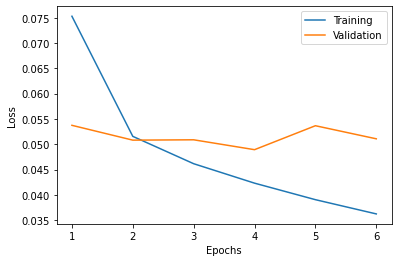

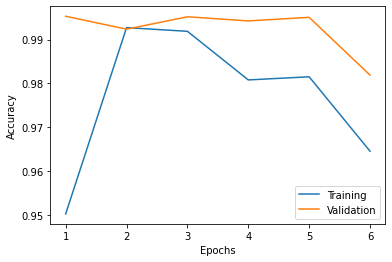

History for fold 3 ...


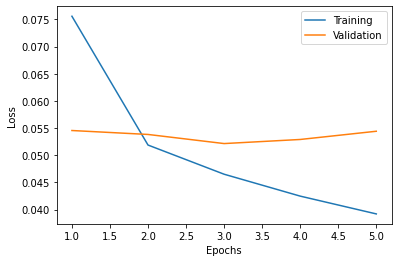

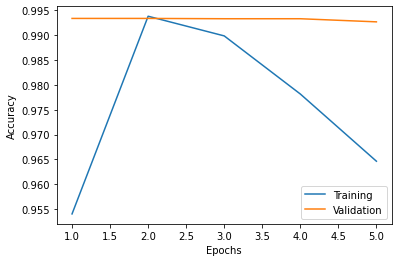

History for fold 4 ...


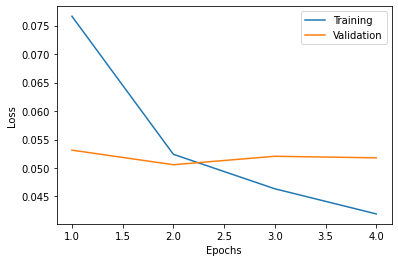

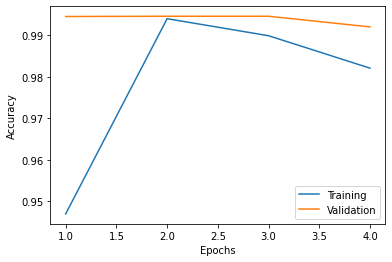

History for fold 5 ...


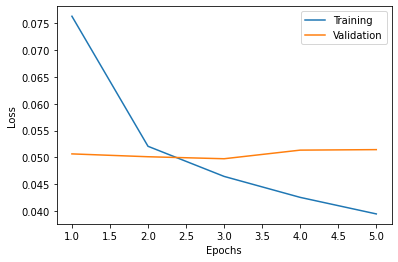

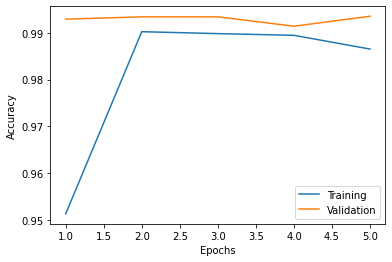

History for fold 6 ...


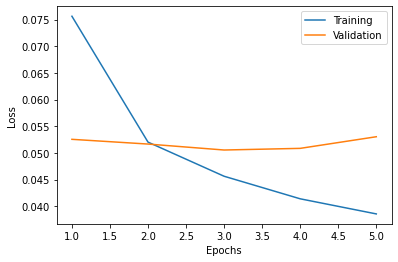

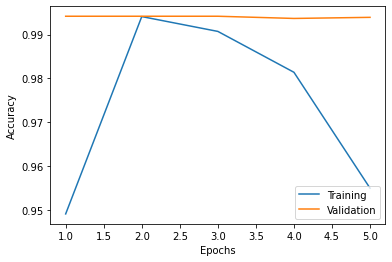

History for fold 7 ...


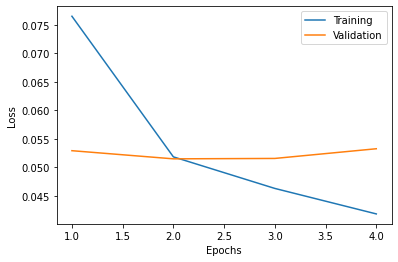

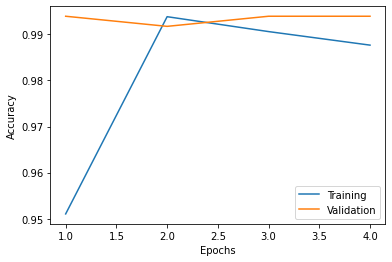

History for fold 8 ...


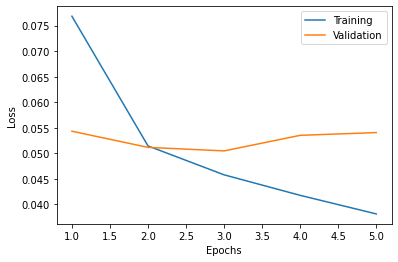

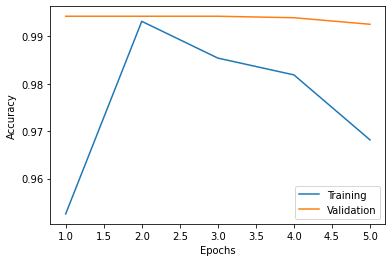

History for fold 9 ...


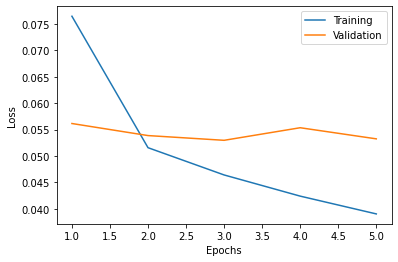

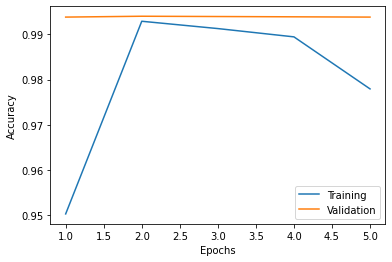

In [ ]:
for hist in range(len(cnn_hist5)):
  print(f'History for fold {hist} ...')
  plot_history(cnn_hist5[hist], len(cnn_hist5[hist].history['val_loss']))

In [ ]:
f1_scores_model5 = []

for fold in range(10):
  epoch =  np.argmin(cnn_hist5[fold].history['val_loss'], axis=0)
  f1_scores_model5.append(cnn_hist5[fold].history['val_f1_m'][epoch])

f1_scores_model5

[0.7165402173995972,
 0.7200255990028381,
 0.7289438843727112,
 0.7143383622169495,
 0.7271143794059753,
 0.7112618684768677,
 0.7294626235961914,
 0.7080090045928955,
 0.7199215888977051,
 0.7074790000915527]

# Best model selection

In [ ]:
scores = [f1_scores_model, f1_scores_model2,f1_scores_model3, f1_scores_model4, f1_scores_model5]
for score in scores:
  mean, min,max = mean_confidence_interval(score)
  data_dict['lower'].append(min)
  data_dict['mean'].append(mean)
  data_dict['upper'].append(max)

data_dict

{'category': ['Model_1', 'Model_2', 'Model_3', 'Model_4', 'Model_5'],
 'lower': [0.6872983995546849,
  0.7085775937022513,
  0.704587918831675,
  0.706102838683267,
  0.7124081564924705],
 'mean': [0.6939581036567688,
  0.7153242766857147,
  0.713786506652832,
  0.7130484819412232,
  0.7183096528053283],
 'upper': [0.7006178077588527,
  0.7220709596691782,
  0.7229850944739891,
  0.7199941251991794,
  0.7242111491181862]}

([<matplotlib.axis.YTick at 0x7f846bea0d30>,
 [Text(0, 0, 'Model_1'),
  Text(0, 0, 'Model_2'),
  Text(0, 0, 'Model_3'),
  Text(0, 0, 'Model_4'),
  Text(0, 0, 'Model_5')])

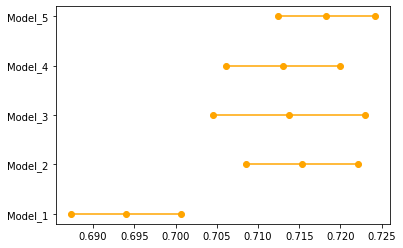

In [ ]:
dataset = pd.DataFrame(data_dict)
for lower,mean,upper,y in zip(dataset['lower'],dataset['mean'], dataset['upper'], range(len(dataset))):
    plt.plot((lower,mean,upper),(y,y,y),'ro-',color='orange')
plt.yticks(range(len(dataset)),list(dataset['category']))

## Test Performance

# Best model evaluation on test set

In [ ]:
best_cnn_model = Sequential()
best_cnn_model.add(Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims))
best_cnn_model.add(SpatialDropout1D(0.3))
best_cnn_model.add(Conv1D(filters=60, kernel_size=4, padding='same', activation='relu', kernel_initializer=initializer)) # ... 100 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
best_cnn_model.add(BatchNormalization()) # add normalization layer
best_cnn_model.add(GlobalMaxPool1D()) # add pooling layer 
best_cnn_model.add(Dropout(0.3))
best_cnn_model.add(Dense(20, activation='relu', kernel_initializer=initializer ))
best_cnn_model.add(Dense(6, activation='sigmoid', kernel_initializer=initializer))

best_cnn_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', f1_m])

In [ ]:
network_history = best_cnn_model.fit(X_train, y_train, batch_size=256, 
                            epochs=10, verbose=2, validation_split=0.2, callbacks=callback)

Epoch 1/10
499/499 - 24s - loss: 0.0780 - accuracy: 0.9462 - f1_m: 0.5797 - val_loss: 0.0544 - val_accuracy: 0.9937 - val_f1_m: 0.6999
Epoch 2/10
499/499 - 23s - loss: 0.0520 - accuracy: 0.9932 - f1_m: 0.7128 - val_loss: 0.0534 - val_accuracy: 0.9940 - val_f1_m: 0.7072
Epoch 3/10
499/499 - 23s - loss: 0.0465 - accuracy: 0.9931 - f1_m: 0.7382 - val_loss: 0.0535 - val_accuracy: 0.9933 - val_f1_m: 0.7022
Epoch 4/10
499/499 - 23s - loss: 0.0418 - accuracy: 0.9922 - f1_m: 0.7621 - val_loss: 0.0546 - val_accuracy: 0.9939 - val_f1_m: 0.6941


In [ ]:
y_pred =  best_cnn_model.predict(X_test) > 0.5
conf_matrix = multilabel_confusion_matrix(y_test, y_pred)

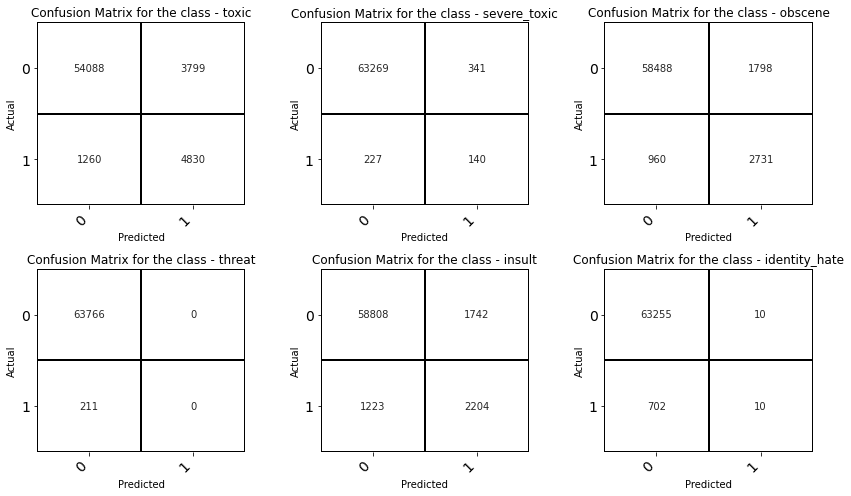

In [ ]:
labels = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

fig, ax = plt.subplots(2, 3, figsize=(12, 7))
    
for axes, cfs_matrix, label in zip(ax.flatten(), conf_matrix, labels):
    print_confusion_matrix(cfs_matrix, axes, label, ["0", "1"])

fig.tight_layout()
plt.show()  

In [ ]:
y_pred =  best_cnn_model.predict(X_test)
score = best_cnn_model.evaluate(X_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])
y_pred =  best_cnn_model.predict(X_test) > 0.5
print(classification_report(y_test, y_pred, zero_division=1))

Test loss: 0.07876694202423096
Test accuracy: 0.9778045415878296
              precision    recall  f1-score   support

           0       0.56      0.79      0.66      6090
           1       0.29      0.38      0.33       367
           2       0.60      0.74      0.66      3691
           3       1.00      0.00      0.00       211
           4       0.56      0.64      0.60      3427
           5       0.50      0.01      0.03       712

   micro avg       0.56      0.68      0.62     14498
   macro avg       0.59      0.43      0.38     14498
weighted avg       0.57      0.68      0.60     14498
 samples avg       0.93      0.97      0.91     14498

